In [2]:
import os 
import sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

In [3]:
import tensorflow as tf
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils_vis import plot_comparison

In [4]:
def create_ran_numbers(img_size):
    '''
    Function to create random coordinates 
    
    @param img_size: Image size 
    
    return:
    random generated x,y coordinates 
    '''
    c1=np.random.randint(img_size, size=1)
    c2=np.random.randint(img_size, size=1)
    c1=tf.convert_to_tensor( c1,dtype=None,dtype_hint=None,name=None)
    c2=tf.convert_to_tensor( c2,dtype=None,dtype_hint=None,name=None)
    return c1,c2

@tf.function
def create_tf_tilecords(coord_list, img_size):
    o1,o2=coord_list
    multiply=tf.constant([img_size*img_size])
    y1=tf.reshape(tf.tile(o1,multiply),[img_size,img_size,1])
    y2=tf.reshape(tf.tile(o2,multiply),[img_size,img_size,1])

    y=tf.concat((y1,y2),axis=2)

    return tf.dtypes.cast(y, tf.float32),tf.dtypes.cast(coord_list, tf.float32)

@tf.function
def tf_create_onehotcords(dat):
    o1,o2=dat
    y1=tf.one_hot(o1,100)
    y2=tf.one_hot(o2,100)
    y2=tf.transpose(y2)
    y=tf.math.multiply(y1,y2)
    #y=tf.transpose(y)
    return y

def create_dat_samples(n):
    '''
    Function to create stacks of coordinates, tiled coordinates, one hot images
    @param n: number of neurons
    '''
    ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    tb = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    coords = tf.TensorArray(tf.float32, size=0, dynamic_size = True)
    for _ in tf.range(n):
        dat=create_ran_numbers(img_size=100)
        b1,b2=create_tf_tilecords(dat, 100)
        c1=tf_create_onehotcords(dat)
        c1=tf.expand_dims(c1, axis=2, name=None)
        
        #tile coordinates
        ta = ta.write(_, b1/99)  #(n, img_size, img_size, 1)
        #one hot images
        tb = tb.write(_, c1) #(n, img_size, img_size, 1)
        #coordinates
        coords = coords.write(_, dat) #(n, 2, 1)
    return coords.stack(), ta.stack(),tb.stack()

def neuron_like_image(n_neurons):
    '''
    Function to paint neuron-like images
     @param n_neurons: number of neurons
    '''
    _,_,one_hot_imgs = create_dat_samples(n_neurons)
    stack_imgs = tf.reduce_sum(one_hot_imgs, axis = 0)
    return tf.expand_dims(stack_imgs, axis = 0) #(1, img_size, img_size, 1)

def stack4plot(one_hot_imgs):
    '''
    Functions to sum all one hot images along axis=0 for easy plot
    '''
    return tf.squeeze(tf.reduce_sum(one_hot_imgs, axis = 0))

In [5]:
n_neurons = 40
img_size = 100
coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[40 1 1 2]


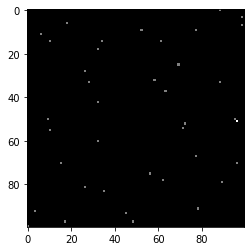

In [6]:
plt.imshow(stack4plot(ori_one_hot_imgs), cmap = 'gray')
plt.show()

In [7]:
#load roi mask
roi_img = np.load('DG-13-8-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))

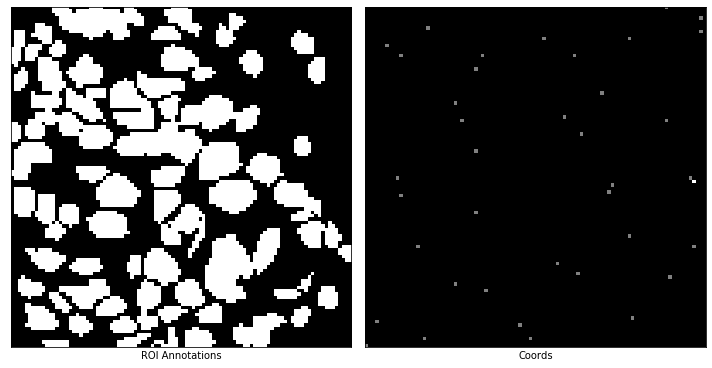

In [8]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Coords']
img_row03 = [roi_img,stack4plot(ori_one_hot_imgs)]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

In [183]:
def overlapMasks(mask_truth, mask_predicted): 
    
    colors = [(0, 0, 0), (0, 1, 0), (0, 0, 0.9)] 
    cm = LinearSegmentedColormap.from_list('mylist', colors, 3)  
    
    #Create mask for overlay, take only activated neurons from one hot im
    Image2_mask = np.ma.masked_array(mask_truth, mask_predicted > 0)
    plt.imshow(Image2_mask, cmap=cm)
    

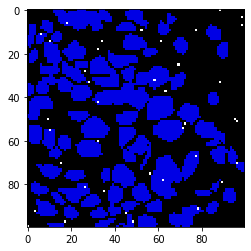

In [194]:
overlapMasks(roi_img, stack4plot(ori_one_hot_imgs))

In [187]:
def getConfusionMatrix(mask_truth, mask_predicted):

    #Create masks

    mask_truth = mask_truth > 0
    mask_truth = np.multiply(mask_truth ,1)
    mask_predicted = mask_predicted > 0 
    mask_predicted = np.multiply(mask_predicted ,1)

    #True Positives: Predicted correctly as Neuron 
    overlap = np.multiply(mask_truth ,mask_predicted)
    unique, counts = np.unique(overlap, return_counts=True)
    TP = counts[1] / overlap.size

    # False Positives: Predicted as neuron, but is no neuron
    FPmask = np.subtract(mask_truth, mask_predicted)
    FP = np.count_nonzero(FPmask == -1)
    FP = FP / FPmask.size

    # False Negatives: Is Neuron but was not predicted
    FNmask = np.subtract(mask_predicted, mask_truth)
    FN = np.count_nonzero(FNmask == -1)
    FN = FN / FNmask.size
    
    #True Nagatives: Is correctly recognized as no neuron
    TN = 1 - TP - FP - FN
    

    print("True Positives", TP)
    print("True Negatives Ratio:", TN)
    print("False Positive Ratio:", FP)
    print("False Negatives Ratio:", FN)

    return TP, TN, FP, FN

In [188]:
getConfusionMatrix(roi_img, stack4plot(ori_one_hot_imgs))


True Positives 0.0011
True Negatives Ratio: 0.5951
False Positive Ratio: 0.0028
False Negatives Ratio: 0.401


(0.0011, 0.5951, 0.0028, 0.401)

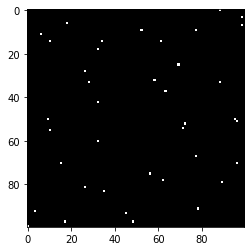

In [185]:
overlapMasks(stack4plot(ori_one_hot_imgs), stack4plot(ori_one_hot_imgs))

In [186]:
getConfusionMatrix(stack4plot(ori_one_hot_imgs), stack4plot(ori_one_hot_imgs))

True Positives 0.0039
False Negatives Ratio: 0.9961
False Positive Ratio: 0.0
False Negatives Ratio: 0.0


(0.0039, 0.9961, 0.0, 0.0)

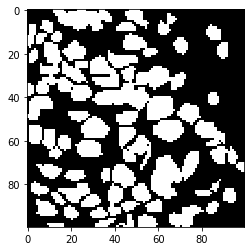

In [192]:
overlapMasks(roi_img,roi_img)

In [193]:
getConfusionMatrix(roi_img, roi_img)

True Positives 0.4021
True Negatives Ratio: 0.5979
False Positive Ratio: 0.0
False Negatives Ratio: 0.0


(0.4021, 0.5979, 0.0, 0.0)

In [210]:
def f1score(TP, FP, FN): 
    f1 = 2*TP / (2*TP + FP + FN)
    return f1

In [213]:
confMatrix = getConfusionMatrix(roi_img, roi_img)


True Positives 0.4021
True Negatives Ratio: 0.5979
False Positive Ratio: 0.0
False Negatives Ratio: 0.0


In [214]:
print(f1score(confMatrix[0], confMatrix[2], confMatrix[3]))

1.0
